In [2]:
import pandas as pd
pd.set_option('use_inf_as_na', True)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
import lightgbm as lgb

In [4]:
np.random.seed(123)

In [5]:
optimal_feature_names_gb = [
    f"opt_feature_files/gb_opt_feat_{x}.pkl"
    for x in range(1, 4)
]
optimal_feature_names_rf = [
    f"opt_feature_files/opt_feat_{x}.pkl"
    for x in range(1, 7)
]

optimal_feature_names_ada = [
    f"opt_feature_files/ada_opt_feat_{x}.pkl"
    for x in range(1, 7)
    if x != 2
]

In [6]:
optimal_features_gb = [pd.read_pickle(name) for name in optimal_feature_names_gb]
optimal_features_rf = [pd.read_pickle(name) for name in optimal_feature_names_rf]
optimal_features_ada = [pd.read_pickle(name) for name in optimal_feature_names_ada]

In [7]:
def process_raw_data(dataset_name: str, can_drop_cols=False):
    data = pd.read_pickle(dataset_name)
    if "market_cap" in data.columns:
        data = data[data['market_cap'] > 1000.0].copy()
    if not can_drop_cols:
        data.replace([np.inf, -np.inf], np.nan, inplace=True)
        data.fillna(0., inplace=True)
    else:
        cols_to_keep = [
            "next_period_return", 
            "spy_next_period_return", 
            "pred_rel_return",
        ]
        data.fillna(
            {c: 0. for c in cols_to_keep}, 
            inplace=True
        )
        data.dropna(
            axis="columns",
            inplace=True
        )
    return data.reset_index().set_index("date")

In [8]:
data = process_raw_data("dataset.pkl")

In [9]:
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_815.0,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,0
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,0.000,...,0,0,0,0,0,0,0,0,0,0
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,0.000,...,0,0,0,0,0,0,0,0,0,0
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,0
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,0


In [10]:
np.isinf(data.drop(columns="ticker")).any().any()

False

In [11]:
print(optimal_features_gb[0])

[Index(['at_turnq'], dtype='object'), Index(['capxq'], dtype='object'), Index(['prccq'], dtype='object'), Index(['oancfy_q', 'chechy', 'capeiq', 'cshiq', 'pe_op_dilq', 'rectq',
       'int_debtq', 'rect_turnq'],
      dtype='object'), Index(['oancfy_q', 'capeiq', 'oiadpq'], dtype='object'), Index(['prccq'], dtype='object'), Index(['oancfy_q'], dtype='object'), Index(['oancfy_q', 'evmq', 'capeiq', 'lt_ppentq', 'opcfq', 'epsfxq',
       'debt_assetsq', 'txpdy'],
      dtype='object'), Index(['lt_ppentq'], dtype='object'), Index(['oepsxy', 'efftaxq', 'lt_ppentq', 'cheq', 'cfmq', 'pretret_noaq',
       'cash_ltq', 'oancfy_q', 'book_value_yield', 'int_totdebtq', 'oibdpq',
       'fcf_yield', 'opmbdq', 'capeiq', 'xsgay'],
      dtype='object'), Index(['capxq'], dtype='object'), Index(['pretret_noaq'], dtype='object'), Index(['oepsxy', 'cheq', 'efftaxq', 'oancfy_q', 'pay_turnq', 'pretret_noaq',
       'fcf_yield', 'chechy', 'short_debtq', 'cash_ltq'],
      dtype='object'), Index(['fcf_yield'

### Generalizable class to tune a generic tree-based classifier (e.g. RandomForestClassifier)

In [12]:
from typing import Tuple, Callable, List
from enum import Enum, auto
import itertools
from collections import OrderedDict
import heapq

class TreeClassifier:
    BAGGING = auto()
    RANDOM_FOREST = auto()
    ADA_BOOST = auto()
    GBM = auto()  # Light Gradient Boosting Machine
    
class TreeClassifierExperiment:
    """
    Given a classifier and dataset, split it into train, test, and validation sets.
    Optimize for profit over the validation set, 
    and return strategy metric ratios over the test set.
    """
    non_feature_cols = [
        'ticker',
        'date',
        'next_period_return',
        'spy_next_period_return',
        'rel_performance',
        'pred_rel_return',
        'return', 
        'cum_ret', 
        'spy_cum_ret',
    ]

    def __init__(
        self,
        classifier: TreeClassifier, 
        data: pd.DataFrame,
        train_period: Tuple[str, str],
        valid_period: Tuple[str, str],
        test_period: Tuple[str, str],
        optimal_features: List = None,
        random_state: int = 123,
    ):
        self.train_period = train_period
        self.valid_period = valid_period
        self.test_period = test_period
        self.classifier = classifier
        self.data = data
        self.random_state = random_state
        self.optim_feats = optimal_features
        self.df_train = data.loc[train_period[0]: train_period[1]].copy()
        self.df_valid = data.loc[valid_period[0]: valid_period[1]].copy()
        self.df_test = data.loc[test_period[0]: test_period[1]].copy()
        self.train = self.df_train.reset_index().drop(
            columns=self.non_feature_cols
        )
        self.valid = self.df_valid.reset_index().drop(
            columns=self.non_feature_cols
        )
        self.test = self.df_test.reset_index().drop(
            columns=self.non_feature_cols
        )
        self.train_features = self.train.values
        self.train_labels = self.df_train["rel_performance"].values
        self.features = None  # to be filled in 
        self.train_filtered = None 
        self.valid_filtered = None
        self.train_filtered_features = None
        self.profits = None
        self.feat = None
        self.comparison_df = None
    
    def run(self, **kwargs):  # kwargs are passed through to classifiers
        clf = self.get_classifier(**kwargs)
        if self.classifier == TreeClassifier.BAGGING:
            self.create_filtered_feature_importance_data()
            self.optim_feats = self.optimize_for_profit()
        test_pnl = self.gen_optimal_model_pnl_on_test_set(clf)
        self.comparison_df = self.get_cumulative_results_vs_spy(
            test_pnl
        )
        self.calc_strategy_metrics(self.comparison_df)
        
    def get_classifier(self, **kwargs):
        if "optimal_features" in kwargs:
            del kwargs["optimal_features"]
        if self.classifier == TreeClassifier.BAGGING:
            return self.get_bagging_classifier(**kwargs)
        elif self.classifier == TreeClassifier.GBM:
            return self.get_gradient_boosting_classifier(**kwargs)
        elif self.classifier == TreeClassifier.RANDOM_FOREST:
            return self.get_random_forest_classifier(**kwargs)
        elif self.classifier == TreeClassifier.ADA_BOOST:
            return self.get_ada_boost_classifier(**kwargs)
        else:
            raise ValueError(f"Got undefined TreeClassifier {self.classifier}")

    def get_gradient_boosting_classifier(self, **kwargs):
        """
        Return an instance of the Light Gradient Boosting Machine
        classifier.
        
        Relevant kwargs:
            - n_estimators: number of iterative models to construct additively
            - objective: not variable within the context of a specific problem
            - min_child_samples: alias for min_data_in_leaf, i.e. do not split 
            if a resulting leaf would have less than this number of points
            - num_leaves: maximum number of leaves in each tree,
            high numbers can lead to overfitting 
            - reg_lambda: L2 regularization coefficient
            - learning_rate: shrinkage rate on the gradient
        """
        return lgb.LGBMClassifier(
            **kwargs,
            random_state=self.random_state,
        )
    
    def get_random_forest_classifier(self, **kwargs):
        """
        Return an instance of the random forest classifier.
        
        Relevant kwargs: 
            - n_estimators: number of models to train
            - max_features: features to look at, at each split
            - min_samples_leaf: threshold below which to stop splitting
            - max_depth: max number of succesive splits
        """
        return RandomForestClassifier(
            **kwargs, 
            random_state=self.random_state,
            bootstrap=True,
        )
    
    def get_ada_boost_classifier(self, **kwargs):
        """
        Return an instance of the adaptive boosting classifier.
        
        Relevant kwargs:
            - n_estimators: number of models to iteratively train
            - learning_rate: speed at which weights are updated
        """
        return AdaBoostClassifier(
            **kwargs,
            random_state=self.random_state,
        )
    
    def get_bagging_classifier(self, **kwargs):
        """
        Return an instance of the bagging classifier.
        """
        try:
            max_depth = kwargs["max_depth"]
            min_samples_leaf = kwargs["min_samples_leaf"]
            n_estimators = kwargs["n_estimators"]
        except:
            raise ValueError(f"Missing at least one required kwarg. Got {kwargs}")
                             
        t_clf = DecisionTreeClassifier(
            max_depth=max_depth, 
            min_samples_leaf=min_samples_leaf
        )
        bg_clf = BaggingClassifier(
            t_clf, 
            n_estimators=n_estimators, 
            oob_score=True,
            random_state=self.random_state, 
            n_jobs=1
        )
        return bg_clf
        
    def create_filtered_feature_importance_data(self, fi_threshold=0.):
        """
        Initial filter for feature importance > 0 to reduce computations.
        """
        bg_clf = self.get_classifier()
        bg_clf.fit(self.train_features, self.train_labels)
        self.orig_bg_clf = bg_clf
        inital_score = bg_clf.score(self.train_features, self.train_labels)
        print(f"Initial model score: {inital_score}, ")
        if self.classifier == TreeClassifier.BAGGING:
            print(f"initial OOB score: {bg_clf.oob_score_}")
        fi = self.baggingtree_feat_importance(bg_clf, self.train)
        self.features = fi[(fi['feat_imp'] > fi_threshold)]
        print(f"Original num features: {len(fi)}, "
              f"num features retained: {len(self.features)}")
        
        self.train_filtered = self.train[self.features['cols'].values]
        self.valid_filtered = self.valid[self.features['cols'].values]
        self.train_filtered_features = self.train_filtered.values
        
    def optimize_for_profit(self):
        profits = []
        feat=[]

        train = self.train_filtered.copy()
        validation = self.valid_filtered.copy()
        
        bg_clf = self.get_classifier()
        while len(train.columns) > 1:
            bg_clf.fit(train, self.train_labels)
            pi = self.baggingtree_profit_importance(
                bg_clf, 
                validation, 
                self.df_valid['next_period_return']
            )

            col_to_drop = pi[
                pi['pi_imp'] == pi['pi_imp'].max()
            ]['cols'].iloc[0]
            train.drop(col_to_drop,axis=1,inplace=True)
            validation.drop(col_to_drop,axis=1,inplace=True)
            bg_clf.fit(train, self.train_labels)
            fi = self.baggingtree_feat_importance(bg_clf, train)
            features = fi[(fi['feat_imp'] > 0.00)]
            train = train[features['cols'].values]
            validation = validation[features['cols'].values]
            bg_clf.fit(train, self.train_labels)
            pred_valid = bg_clf.predict(validation)
            profits.append(
                (pred_valid * self.df_valid['next_period_return'])
                .sum()
            )
            feat.append(features['cols'].values)
        
        self.profits = profits
        self.feat = feat
        n = np.argmax(profits)
        optim_feats = feat[n]
        max_profits = profits[n]
        print(f"Max profits: {max_profits}, "
              f"optimal features: {optim_feats}")
        return optim_feats

    def baggingtree_profit_importance(self, m, df, rets):
        return pd.DataFrame(
            {
                'cols':df.columns, 
                'pi_imp': self.profit_importance(m,df,rets)
            }
        ).sort_values('pi_imp', ascending=True)

    @staticmethod
    def profit_importance(t, df, rets):
        np.random.seed(123)
        profit = []
        for col in df.columns:
            prof = []
            for _ in range(20):
                X = df.copy()
                X[col] = np.random.permutation(df[col].values)
                prediction = t.predict(X)
                prof.append((prediction * rets).sum())
            profit.append(np.mean(prof))
        return profit

    @staticmethod
    def baggingtree_feat_importance(m, df):
        feature_importances = []
        for est in m.estimators_:
            fi = est.feature_importances_
            feature_importances.append(fi)
        feature_importances = np.array(feature_importances)

        return pd.DataFrame(
            {
                'cols':df.columns, 
                'feat_imp':np.mean(feature_importances,axis=0)
            }
        ).sort_values('feat_imp', ascending=False)

    @staticmethod
    def plot_fi(fi): 
        """
        Optional helper method to plot features
        """
        return fi.plot('cols', 'feat_imp', 'barh', 
                       figsize=(12,7), legend=False)

    def gen_optimal_model_pnl_on_test_set(self, bg_clf):
        num_testable_quarters = self.calc_num_testable_quarters(
            self.test_period[0],
            self.test_period[1],
        )
        start_dates = [
            pd.to_datetime(str(self.test_period[0])) 
            + pd.DateOffset(months = 3 * i) 
            for i in range(num_testable_quarters)
        ]
        
        print(f"First training period start: {start_dates[0]}, "
              f"Last training period start: {start_dates[-1]}, "
              f"\n Number of training periods: {len(start_dates)}")
        
        end_dates = [
            d + pd.DateOffset(months = 36) 
            for d in start_dates
        ]
        self.end_dates = end_dates
        
        training_frames = [
            self.data.loc[d:d+pd.DateOffset(months = 36)] 
            for d in start_dates
        ]
        test_frames = [
            self.data.loc[
                d + pd.DateOffset(months=3)
                :d+pd.DateOffset(months = 6)
            ] 
            for d in end_dates
        ]

        training_data = [
            d.reset_index().drop(
                ['ticker','date',
               'next_period_return',
               'spy_next_period_return',
               'rel_performance','pred_rel_return',
              'return', 'cum_ret', 'spy_cum_ret'
                ]
                ,axis=1
            ) for d in training_frames
        ]

        test_data = [
            d.reset_index().drop(
            ['ticker','date',
               'next_period_return',
               'spy_next_period_return',
               'rel_performance','pred_rel_return',
              'return', 'cum_ret', 'spy_cum_ret'
            ]
            ,axis=1
            ) for d in test_frames
        ]

        training_labels = [
            d['rel_performance'].values 
            for d in training_frames
        ]
        if self.classifier == TreeClassifier.BAGGING:
            opt_training_data = [
                t[self.optim_feats] 
                for t in training_data
            ]
            opt_test_data = [
                v[self.optim_feats] 
                for v in test_data
            ]
        else:
            opt_training_data = [
                t[opt_feats] 
                for t, opt_feats in zip(training_data, self.optim_feats)
            ]
            opt_test_data = [
                v[opt_feats] 
                for v, opt_feats in zip(test_data, self.optim_feats)
            ]

        return self.fit_and_predict_over_training_period(
            bg_clf,
            training_labels, 
            opt_training_data, 
            opt_test_data,
            test_frames,
        )

    @staticmethod
    def calc_num_testable_quarters(start_timestamp, end_timestamp):
        return (
            pd.Timestamp(end_timestamp) 
            - (pd.Timestamp(start_timestamp) 
               + pd.DateOffset(months = 36))
        ) // (pd.Timedelta("1d")*365/4) + 1
        
    @staticmethod
    def fit_and_predict_over_training_period(
        bg_clf,
        training_labels, 
        opt_training_data, 
        opt_test_data,
        test_frames,
    ):
        P_L = []
        strat_ret = [1]
        ret = []

        for i in range(len(training_labels) - 1):
            bg_clf.fit(opt_training_data[i],training_labels[i])
            pred_i = bg_clf.predict(opt_test_data[i])
            profit_i = (
                pred_i * test_frames[i]['next_period_return']
            ).sum()
            P_L.append(profit_i)
            num_positions = len(pred_i)
            ret.append((1.0/num_positions) * profit_i)
            strat_ret.append(
                strat_ret[i] + (strat_ret[i]/num_positions) * profit_i
            )

        return strat_ret
    
    def get_cumulative_results_vs_spy(self, test_profits, freq="Q"):
        comparison = pd.read_pickle(
            f"/Users/tai/FINM 33160 Machine Learning In Finance/"
            f"Lecture 2/SPY_cum_ret.pkl"
        )
        comparison = comparison.loc[
            self.end_dates[0] + pd.DateOffset(months=9)
            :self.end_dates[-1] + pd.DateOffset(months=9)
        ]
        comparison = comparison.resample(freq).ffill()
        comparison['spy_cum_ret'] = (
            comparison['spy_cum_ret'] - comparison['spy_cum_ret'][0] + 1
        )
        comparison["strategy"] = test_profits[1:]
        
        return comparison
    
    @classmethod
    def calc_strategy_metrics(cls, comparison):
        cls.calc_sr(comparison)
        
        comparison_annual = comparison.resample('A').ffill()
        cls.calc_sr(comparison_annual, quarterly=False)

        strategy_ret = (comparison['strategy'] - 1).diff().values[1:]
        spy_ret = (comparison['spy_cum_ret'] - 1).diff().values[1:]

        beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
        print(f"Strategy beta: {beta}")

        residual_ret = strategy_ret - beta * spy_ret
        IR = np.mean(residual_ret)/np.std(residual_ret)
        print(f"Strategy information ratio: {IR}")

        alpha = np.mean(residual_ret)
        print(f"Strategy alpha: {alpha}")

    @classmethod
    def calc_sr(cls, comparison_df, quarterly=True):
        strategy_mean_ret, strategy_std = (
            cls.calc_mean_and_std(comparison_df['strategy'])
        )
        strategy_sr = strategy_mean_ret/strategy_std
        
        spy_mean_ret, spy_std = (
            cls.calc_mean_and_std(comparison_df['spy_cum_ret'])
        )
        spy_sr = spy_mean_ret/spy_std
        
        freq = "Quarterly" if quarterly else "Annual"
        print(f"Strategy {freq} Sharpe Ratio: {strategy_sr}, "
              f"SPY {freq} Sharpe Ratio: {spy_sr}")
        
    @staticmethod
    def calc_mean_and_std(col):
        diffs = (col - 1).diff()
        return diffs.mean(), diffs.std()

In [13]:
class Helpers:
    @staticmethod
    def grid_search(
        classifier: TreeClassifier, 
        params: dict,
        optim_func: Callable,  # function evaluated over the pnl series, optimization is minimization
        data: pd.DataFrame,
        train_period: Tuple[str, str],
        valid_period: Tuple[str, str],
        test_period: Tuple[str, str],
        optimal_features: List,
    ):
        """
        params should contain possible values for kwargs 
        
        Returns tuples of scores based on the input optimization
        function stored in a min heap, as the objective is 
        assumed to minimization (e.g. for max drawdown)
        """
        experiment = TreeClassifierExperiment(
            classifier,
            data,
            train_period,
            valid_period,
            test_period,
            optimal_features,
        )

        labels, param_vals = [], []

        for k, v in params.items():
            labels.append(k)
            param_vals.append(v)

        values_combos = itertools.product(*param_vals)
        min_heap = []
        params_dict = dict()
        pnls_dict = dict()
        
        for idx, combo in enumerate(values_combos):
            param_combo = dict()
            for l, v in zip(labels, combo):
                param_combo[l] = v
            print(f"Run {idx} Hyperparameters: {param_combo}")
            experiment.run(**param_combo)
            optim_val = optim_func(
                experiment.comparison_df.strategy.values
            )
            print(f"{optim_func.__name__} value as "
                  f"a function of pnl: {optim_val} \n")
            heapq.heappush(min_heap, (optim_val, idx))
            params_dict[idx] = param_combo
            pnls_dict[idx] = experiment.comparison_df
        
        print(f"Optimal value of {optim_func.__name__}: {min_heap[0][0]}")
        print(f"Optimal parameters: {params_dict[min_heap[0][1]]}")
        
        return min_heap, params_dict, pnls_dict
                  
    @staticmethod
    def calc_max_drawdown(pnls: List):
        if pnls is None:
            return 0
        
        cur_max = pnls[0]
        max_drawdown = 0
        
        for p in pnls[1:]:
            if p > cur_max:
                cur_max = p
            elif cur_max - p > max_drawdown:
                max_drawdown = cur_max - p
        
        return max_drawdown

### Grid search for best set of hyperparameters

- Using the base case labeling of -1 for underperformance and +1 for outperformance over SPY for the first pass
    - Insert a column in the data set where the entries are 1 if the stock outperforms SPY in the earnings period and -1 if it underperforms or has the same return.

In [41]:
data["rel_performance"] = (
    pd.cut(data["pred_rel_return"],
           [-np.inf, -.01, .01, np.inf],
           labels=[-1,0,1],
          ).values
)

In [42]:
data["pred_rel_return"].head()

date
2000-02-09   -0.025923
2000-02-09    0.066175
2000-02-10    0.241345
2000-02-11    0.306035
2000-02-15    0.043852
Name: pred_rel_return, dtype: float64

In [43]:
data["rel_performance"].head()

date
2000-02-09   -1
2000-02-09    1
2000-02-10    1
2000-02-11    1
2000-02-15    1
Name: rel_performance, dtype: category
Categories (3, int64): [-1 < 0 < 1]

In [44]:
data.head()

,ticker,actq,apq,atq,ceqq,cheq,cogsq,csh12q,cshfdq,cshiq,...,sector_code_817.0,sector_code_822.0,sector_code_823.0,sector_code_825.0,sector_code_830.0,sector_code_835.0,sector_code_840.0,sector_code_845.0,sector_code_850.0,rel_performance
date,,,,,,,,,,,,,,,,,,,,,
2000-02-09,CSCO,7722.000,482.000,21391.000,16523.000,3968.000,1422.000,3374.1250,3648.000,3445.000,...,0,0,0,0,0,0,0,0,0,-1
2000-02-09,ROP,172.725,19.662,474.649,239.432,3.198,47.634,30.2688,31.217,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-10,CMOS,240.767,27.044,376.536,209.411,68.625,43.023,21.4360,23.753,0.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-11,DELL,7681.000,3538.000,11471.000,5308.000,4132.000,5452.000,2536.0000,2731.000,2575.000,...,0,0,0,0,0,0,0,0,0,1
2000-02-15,VAL,507.082,139.497,1094.080,402.382,27.605,221.366,43.1858,43.687,53.321,...,0,0,0,0,0,0,0,0,0,1


In [55]:
def iterate_over_optimal_features_sets(
    optimal_features_list: List, 
    tree_classifier: TreeClassifier
):
    results_by_opt_feat_set = dict()
    for i, optimal_features in enumerate(optimal_features_list):
        print(f"Outer loop over set of optimal features "
              f"(corresponding to pkl file) {i}: \n")
        if tree_classifier == TreeClassifier.RANDOM_FOREST:
            param_grid = {
                'n_estimators': [5, 15, 25, 40], 
                'max_features': ['sqrt','log2', .3, .5],
                'min_samples_leaf': [1200, 1800, 2400, 3200],
                'max_depth': [3, 10, 15, 25],
            }
        elif tree_classifier == TreeClassifier.ADA_BOOST:
            param_grid = {
                'n_estimators': [15, 25, 50, 75], 
                'learning_rate': [.25, .5, 1., 2.],
            }
        elif tree_classifier == TreeClassifier.GBM:
            param_grid = {
                'n_estimators': [50, 250, 400, 600], 
                'objective': ['multi_class'],
                'min_child_samples': [1800, 2400, 3200],  # alias for min_data_in_leaf
                'num_leaves': [5, 15],
                'reg_lambda': [.5],
                'learning_rate': [.1],
            }
        else:
            raise ValueError(
                f"Unconfigured TreeClassifier {tree_classifier}"
            )
        min_heap, params_dict, pnls_dict = Helpers.grid_search(
            optim_func=Helpers.calc_max_drawdown, 
            classifier=tree_classifier,
            params=param_grid,
            data=data,
            train_period=('2000-02-09', '2003-02-09'), 
            valid_period=('2003-05-09', '2003-08-09'), 
            test_period=('2000-01-01', '2018-04-01'),
            optimal_features=optimal_features,
        )
        results_by_opt_feat_set[i] = {
            "min_heap": min_heap,
            "params_dict": params_dict,
            "pnls_dict": pnls_dict,
        }
    return results_by_opt_feat_set

In [87]:
results_by_opt_feat_set_gb = (
    iterate_over_optimal_features_sets(
        optimal_features_gb, 
        TreeClassifier.GBM
    )
)

Outer loop over set of optimal features (corresponding to pkl file) 0: 

Run 0 Hyperparameters: {'n_estimators': 50, 'objective': 'multi_class', 'min_child_samples': 1800, 'num_leaves': 5, 'reg_lambda': 0.5, 'learning_rate': 0.1}
First training period start: 2000-01-01 00:00:00, Last training period start: 2015-04-01 00:00:00, 
 Number of training periods: 62
Strategy Quarterly Sharpe Ratio: 0.7996827377577777, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 1.6988429780975327, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.3187630531417473
Strategy information ratio: 0.7712273900006216
Strategy alpha: 0.1356054071786195
calc_max_drawdown value as a function of pnl: 0.5541514505264487 

Run 1 Hyperparameters: {'n_estimators': 50, 'objective': 'multi_class', 'min_child_samples': 1800, 'num_leaves': 15, 'reg_lambda': 0.5, 'learning_rate': 0.1}
First training period start: 2000-01-01 00:00:00, Last training period start: 2015-04-01 00:00:00, 
 N

Strategy Quarterly Sharpe Ratio: 1.0342734858503086, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 1.9743444075669614, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.29160241092143757
Strategy information ratio: 1.008349641354754
Strategy alpha: 0.15504993829284136
calc_max_drawdown value as a function of pnl: 0.31107011595551803 

Run 13 Hyperparameters: {'n_estimators': 400, 'objective': 'multi_class', 'min_child_samples': 1800, 'num_leaves': 15, 'reg_lambda': 0.5, 'learning_rate': 0.1}
First training period start: 2000-01-01 00:00:00, Last training period start: 2015-04-01 00:00:00, 
 Number of training periods: 62
Strategy Quarterly Sharpe Ratio: 1.0531777657052253, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 2.073769992075499, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.3052516502405608
Strategy information ratio: 1.0239332678021276
Strategy alpha: 0.14380421351718417
calc_max_drawdown

Strategy Quarterly Sharpe Ratio: 0.7510365859175892, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 1.493855550556935, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.28693906733807
Strategy information ratio: 0.7219978082984619
Strategy alpha: 0.11498452031169377
calc_max_drawdown value as a function of pnl: 0.5483346089950139 

Run 1 Hyperparameters: {'n_estimators': 50, 'objective': 'multi_class', 'min_child_samples': 1800, 'num_leaves': 15, 'reg_lambda': 0.5, 'learning_rate': 0.1}
First training period start: 2000-01-01 00:00:00, Last training period start: 2015-04-01 00:00:00, 
 Number of training periods: 62
Strategy Quarterly Sharpe Ratio: 0.8011933646671706, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 1.51459316875751, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.24228100001809588
Strategy information ratio: 0.777364275049246
Strategy alpha: 0.12255721380793948
calc_max_drawdown value 

Strategy Quarterly Sharpe Ratio: 1.0392493695300213, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 1.9258451924087396, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.28860542905877146
Strategy information ratio: 1.0112639621616526
Strategy alpha: 0.14201373815828264
calc_max_drawdown value as a function of pnl: 0.2982845397184821 

Run 14 Hyperparameters: {'n_estimators': 400, 'objective': 'multi_class', 'min_child_samples': 2400, 'num_leaves': 5, 'reg_lambda': 0.5, 'learning_rate': 0.1}
First training period start: 2000-01-01 00:00:00, Last training period start: 2015-04-01 00:00:00, 
 Number of training periods: 62
Strategy Quarterly Sharpe Ratio: 0.9579582431736858, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 1.7323520093108327, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.2634730516834262
Strategy information ratio: 0.9329353207679084
Strategy alpha: 0.14037453227620375
calc_max_drawdown

Strategy Quarterly Sharpe Ratio: 0.9587451832115115, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 1.8411210832654326, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.2581901512051732
Strategy information ratio: 0.9399357080579318
Strategy alpha: 0.1780338357041278
calc_max_drawdown value as a function of pnl: 0.40319287582703556 

Run 2 Hyperparameters: {'n_estimators': 50, 'objective': 'multi_class', 'min_child_samples': 2400, 'num_leaves': 5, 'reg_lambda': 0.5, 'learning_rate': 0.1}
First training period start: 2000-01-01 00:00:00, Last training period start: 2015-04-01 00:00:00, 
 Number of training periods: 62
Strategy Quarterly Sharpe Ratio: 0.8641655875171245, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 1.830709747624703, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.293734653729105
Strategy information ratio: 0.8396452487084071
Strategy alpha: 0.151229642646788
calc_max_drawdown value 

Strategy Quarterly Sharpe Ratio: 1.0941672913314764, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 2.0128382962890083, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.3344620164336684
Strategy information ratio: 1.0689867887206508
Strategy alpha: 0.18672739347446327
calc_max_drawdown value as a function of pnl: 0.2937528709841821 

Run 15 Hyperparameters: {'n_estimators': 400, 'objective': 'multi_class', 'min_child_samples': 2400, 'num_leaves': 15, 'reg_lambda': 0.5, 'learning_rate': 0.1}
First training period start: 2000-01-01 00:00:00, Last training period start: 2015-04-01 00:00:00, 
 Number of training periods: 62
Strategy Quarterly Sharpe Ratio: 1.0721348178774153, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 2.0686160838490935, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.3404291733225146
Strategy information ratio: 1.0456523570775726
Strategy alpha: 0.1793444758968863
calc_max_drawdown 

In [88]:
def print_results_by_pkl_file(results_by_opt_feat_set: dict):
    min_overall_drawdown = np.inf
    optimal_parameters_file_idx = None
    min_overall_drawdown_idx = None
    min_overall_drawdown_params = None
    min_overall_drawdown_pnls = None

    for idx, res in results_by_opt_feat_set.items():
        max_drawdown = res['min_heap'][0][0]
        print(f"For pkl file {idx}, the smallest max "
              f"drawdown was {max_drawdown} achieved with "
              f"parameters: {res['params_dict'][res['min_heap'][0][1]]} \n")
        if max_drawdown < min_overall_drawdown:
            min_overall_drawdown = max_drawdown
            optimal_parameters_file_idx = idx
            min_overall_drawdown_idx = res['min_heap'][0][1]
            min_overall_drawdown_params = res['params_dict'][res['min_heap'][0][1]]
            min_overall_drawdown_pnls = res['pnls_dict'][res['min_heap'][0][1]]
    return (
        min_overall_drawdown, 
        optimal_parameters_file_idx,
        min_overall_drawdown_idx,
        min_overall_drawdown_params,
        min_overall_drawdown_pnls,
    )

In [89]:
(min_overall_drawdown_gb,
file_idx_gb,
min_overall_drawdown_gb_idx,
min_overall_drawdown_gb_params,
min_overall_drawdown_gb_pnls) = print_results_by_pkl_file(results_by_opt_feat_set_gb)

For pkl file 0, the smallest max drawdown was 0.26729323911388425 achieved with parameters: {'n_estimators': 600, 'objective': 'multi_class', 'min_child_samples': 1800, 'num_leaves': 15, 'reg_lambda': 0.5, 'learning_rate': 0.1} 

For pkl file 1, the smallest max drawdown was 0.2406629363758177 achieved with parameters: {'n_estimators': 600, 'objective': 'multi_class', 'min_child_samples': 1800, 'num_leaves': 15, 'reg_lambda': 0.5, 'learning_rate': 0.1} 

For pkl file 2, the smallest max drawdown was 0.19945564900430046 achieved with parameters: {'n_estimators': 600, 'objective': 'multi_class', 'min_child_samples': 1800, 'num_leaves': 15, 'reg_lambda': 0.5, 'learning_rate': 0.1} 



- Overall smallest maximum drawdown over the params configured for Gradient Boosting classifier:

In [90]:
print(f"{min_overall_drawdown_gb}, for trial {min_overall_drawdown_gb_idx} in pkl file {file_idx_gb}")

0.19945564900430046, for trial 19 in pkl file 2


In [91]:
min_overall_drawdown_gb_params

{'n_estimators': 600,
 'objective': 'multi_class',
 'min_child_samples': 1800,
 'num_leaves': 15,
 'reg_lambda': 0.5,
 'learning_rate': 0.1}

In [92]:
TreeClassifierExperiment.calc_strategy_metrics(min_overall_drawdown_gb_pnls)

Strategy Quarterly Sharpe Ratio: 1.1166180712124911, SPY Quarterly Sharpe Ratio: 0.33079871126133004
Strategy Annual Sharpe Ratio: 2.1990515896752028, SPY Annual Sharpe Ratio: 0.5846194645603067
Strategy beta: 0.33921643884563046
Strategy information ratio: 1.0860541757544144
Strategy alpha: 0.15371256550481407


<AxesSubplot:xlabel='date'>

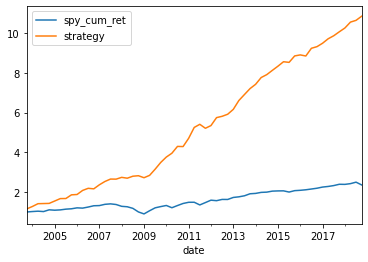

In [93]:
min_overall_drawdown_gb_pnls.plot()